In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg
from scipy.io import loadmat
%matplotlib inline

## Neural Networks

In [2]:
df = loadmat('./ex4/ex4data1.mat')

In [3]:
X = df['X']
y = df['y']
print("X dimension: ", X.shape)
print("y dimension: ", y.shape)

X dimension:  (5000, 400)
y dimension:  (5000, 1)


### Visualizing the data

In [4]:
rand_index = np.random.choice(5000, 100, replace=False)

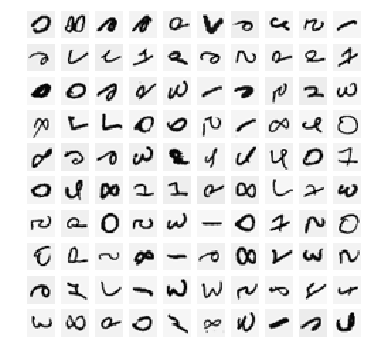

In [13]:
rand_x = X[rand_index].reshape([100, 20, 20])

fig = plt.figure(figsize=(6,6))
for i in range(100):
    fig.add_subplot(10, 10, i+1)
    plt.imshow(rand_x[i], interpolation='nearest', cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

### Model Representation

In [17]:
weights = loadmat('./ex4/ex4weights.mat')

In [18]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
print("Theta1 dimension: ", Theta1.shape)
print("Theta2 dimension: ", Theta2.shape)

Theta1 dimension:  (25, 401)
Theta2 dimension:  (10, 26)


In [19]:
weights_vec = np.r_[Theta1.ravel(), Theta2.ravel()]

### Feedforward and cost function

In [20]:
INPUT_LAYER_SIZE = 400
HIDDEN_LAYER_SIZE = 25
NUM_LABELS = 10

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [22]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, alpha0):
        theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape([hidden_layer_size, input_layer_size + 1])
        theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape([num_labels, hidden_layer_size + 1])
        # dummify y
        labels = np.unique(y)
        y_dummy = (y==labels[0])
        for item in labels[1:]:
            y_dummy = np.c_[y_dummy, y==item]
        
        # compute cost
        m, p = x.shape
        x = np.c_[np.ones([m, 1]), x]
        h1 = sigmoid(np.dot(x, theta1.T))
        h1 = np.c_[np.ones([m, 1]), h1]
        h2 = sigmoid(np.dot(h1, theta2.T))
        cost = -np.mean(np.sum(y_dummy * np.log(h2 + 1e-8) + (1-y_dummy) * np.log(1 - h2 + 1e-8), axis=1))
        return cost

In [23]:
init_cost = nnCostFunction(weights_vec, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X, y, 0)
print("Initial Cost: ", init_cost)

Initial Cost:  0.287629048119


### Regularized cost function

In [24]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, alpha0):
        theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape([hidden_layer_size, input_layer_size + 1])
        theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape([num_labels, hidden_layer_size + 1])
        # dummify y
        labels = np.unique(y)
        y_dummy = (y==labels[0])
        for item in labels[1:]:
            y_dummy = np.c_[y_dummy, y==item]
        
        # compute cost
        m, p = x.shape
        x = np.c_[np.ones([m, 1]), x]
        h1 = sigmoid(np.dot(x, theta1.T))
        h1 = np.c_[np.ones([m, 1]), h1]
        h2 = sigmoid(np.dot(h1, theta2.T))
        cost = -np.mean(np.sum(y_dummy * np.log(h2 + 1e-8) + (1-y_dummy) * np.log(1 - h2 + 1e-8), axis=1))
        # regularization term
        reg_term = (alpha0 / (2*m)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
        cost += reg_term
        
        return cost

In [25]:
init_cost_reg = nnCostFunction(weights_vec, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X, y, 1)
print("Initial Cost: ", init_cost_reg)

Initial Cost:  0.383769742048


## Backpropagation

### Sigmoid gradient

In [26]:
def sigmoidGradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [27]:
[sigmoidGradient(i) for i in [-1, -0.5, 0, 0.5, 1]]

[0.19661193324148185,
 0.23500371220159449,
 0.25,
 0.23500371220159449,
 0.19661193324148185]

### Random initialization

In [28]:
#epsilon_init = 0.12

def randInitializeWeights(nin, nout):
    init_eps = np.sqrt(6 / (nin + nout))
    w = np.random.rand(nout, nin+1) * 2 * init_eps - init_eps
    return w

In [29]:
def debugInitializeWeights(nin, nout):
    w = np.zeros([nout, nin+1])
    w = np.reshape(np.sin(range(1, w.size+1)), w.T.shape).T / 10.0
    return w

In [31]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, alpha0):
        theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape([hidden_layer_size, input_layer_size + 1])
        theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape([num_labels, hidden_layer_size + 1])
        
        # dummify y
        labels = np.unique(y)
        y_dummy = (y==labels[0])
        for item in labels[1:]:
            y_dummy = np.c_[y_dummy, y==item]
        
        # feedforward
        m, p = x.shape
        a1 = np.c_[np.ones([m, 1]), x] # 5000x401
        z2 = np.dot(a1, theta1.T) # 5000x25
        a2 = np.c_[np.ones([m, 1]), sigmoid(z2)] # 5000x26
        z3 = np.dot(a2, theta2.T) # 5000x10
        a3 = sigmoid(z3) # 5000x10
        # reg cost
        cost = -np.mean(np.sum(y_dummy * np.log(a3 + 1e-8) + (1-y_dummy) * np.log(1 - a3 + 1e-8), axis=1))
        reg_term = (alpha0 / (2*m)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
        cost += reg_term
        
        # backprop
        d3 = a3 - y_dummy # 5000x10
        d2 = np.dot(d3, theta2[:,1:]) * sigmoidGradient(z2) # 5000x25
        
        delta1 = np.dot(d2.T, a1) # 25x401
        delta2 = np.dot(d3.T, a2) # 10x26
        
        grad1 = delta1 / m # 25x401
        grad2 = delta2 / m # 10x26
        grad = np.r_[grad1.ravel(), grad2.ravel()]
        return (cost, grad)

### Gradient checking

In [32]:
def computeNumericalGradient(J, theta):
    num = theta.shape[0]
    numgrad = np.zeros(num)
    perturb = np.zeros(num)
    e = 1e-4
    for p in range(num):
        
        # Set purturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # Compute numerical gradient
        numgrad[p] = (loss2[0] - loss1[0]) / (2*e)
        perturb[p] = 0
    return numgrad

In [33]:
def checkNNGradients(Lambda = 0):

    """Creates a small neural network to check the
    backpropagation gradients, it will output the analytical gradients
    produced by your backprop code and the numerical gradients (computed
    using computeNumericalGradient). These two gradient computations should
    result in very similar values.
    https://github.com/mstampfer/Coursera-Stanford-ML-Python/blob/master/ex4/checkNNGradients.py
    """

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(input_layer_size, hidden_layer_size)
    Theta2 = debugInitializeWeights(hidden_layer_size, num_labels)

    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(input_layer_size - 1, m)
    y  = np.mod(range(1, m+1), num_labels)
    
    # Unroll parameters
    nn_params = np.hstack((Theta1.T.ravel(), Theta2.T.ravel()))

    # Short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

    numgrad = computeNumericalGradient(costFunc, nn_params)
    grad = costFunc(nn_params)[1]

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar.
    print(numgrad)
    print(grad)

    print('The above two columns you get should be very similar.\n' \
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    # Evaluate the norm of the difference between two solutions.
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)

    print('If your backpropagation implementation is correct, then\n ' \
          'the relative difference will be small (less than 1e-9). \n' \
          '\nRelative Difference: %g\n' % diff)

In [34]:
checkNNGradients(Lambda = 0)

[  1.23162082e-02   4.74155204e-05   3.34120958e-04   1.42139447e-04
   3.92502038e-03   4.24118340e-05   2.42734701e-04   9.52974810e-05
  -8.08500601e-03  -2.01888506e-06  -7.20774085e-05  -3.88723831e-05
  -1.26669158e-02  -4.44650738e-05  -3.20734166e-04  -1.37495233e-04
  -5.59393309e-03  -4.60789629e-05  -2.74281555e-04  -1.09527649e-04
   3.09346143e-01   1.61185645e-01   1.47076490e-01   1.58094845e-01
   1.57801437e-01   1.47166673e-01   1.08130679e-01   5.62716817e-02
   5.17725490e-02   5.48565371e-02   5.53245339e-02   5.16290351e-02
   1.06267485e-01   5.54097883e-02   5.08118120e-02   5.38939322e-02
   5.44633719e-02   5.06370463e-02]
[  1.23162084e-02   4.74155186e-05   3.34120964e-04   1.42139447e-04
   3.92502047e-03   4.24118332e-05   2.42734709e-04   9.52974829e-05
  -8.08500619e-03  -2.01888853e-06  -7.20774091e-05  -3.88723823e-05
  -1.26669161e-02  -4.44650771e-05  -3.20734171e-04  -1.37495234e-04
  -5.59393321e-03  -4.60789646e-05  -2.74281562e-04  -1.09527650e-0

### Regularized Neural Networks

In [70]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, x, y, alpha0):
        theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape([hidden_layer_size, input_layer_size + 1])
        theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape([num_labels, hidden_layer_size + 1])
        
        # dummify y
        labels = np.unique(y)
        y_dummy = (y==labels[0])
        for item in labels[1:]:
            y_dummy = np.c_[y_dummy, y==item]
        
        # feedforward
        m, p = x.shape
        a1 = np.c_[np.ones([m, 1]), x] # 5000x401
        z2 = np.dot(a1, theta1.T) # 5000x25
        a2 = np.c_[np.ones([m, 1]), sigmoid(z2)] # 5000x26
        z3 = np.dot(a2, theta2.T) # 5000x10
        a3 = sigmoid(z3) # 5000x10
        # reg cost
        cost = -np.mean(np.sum(y_dummy * np.log(a3 + 1e-8) + (1-y_dummy) * np.log(1 - a3 + 1e-8), axis=1))
        reg_term = (alpha0 / (2*m)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
        cost += reg_term
        
        # backprop
        d3 = a3 - y_dummy # 5000x10
        d2 = np.dot(d3, theta2[:,1:]) * sigmoidGradient(z2) # 5000x25
        
        delta1 = np.dot(d2.T, a1) # 25x401
        delta2 = np.dot(d3.T, a2) # 10x26
        
        grad1 = delta1 / m # 25x401
        grad1[:, 1:] += (alpha0/m) * theta1[:, 1:]
        grad2 = delta2 / m # 10x26
        grad2[:, 1:] += (alpha0/m) * theta2[:, 1:]
        grad = np.r_[grad1.ravel(), grad2.ravel()]
        return (cost, grad)

In [71]:
debug_Lambda = 3
checkNNGradients(debug_Lambda)
debug_J = nnCostFunction(weights_vec, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X, y, debug_Lambda)[0]
print("Cost at (fixed) debugging parameters (w/ lambda = {}): {}".format(debug_Lambda, debug_J))
print("For lambda = 3, this value should be about 0.576051.")

[ 0.01231621  0.05460526  0.00880132 -0.04526601  0.00392502 -0.01672252
  0.03966193  0.05945679 -0.00808501 -0.03264329 -0.06007149 -0.03223325
 -0.01266692  0.05939198  0.03869654 -0.01741169 -0.00559393 -0.04510531
  0.00871835  0.05466719  0.30934614  0.21574349  0.15554369  0.1126867
  0.10026598  0.13040174  0.10813068  0.11563318  0.07649966  0.02221527
 -0.00467488  0.01943466  0.10626749  0.11484623  0.08982908  0.03661973
 -0.00322048  0.00557781]
[ 0.01231621  0.05460526  0.00880132 -0.04526601  0.00392502 -0.01672252
  0.03966193  0.05945679 -0.00808501 -0.03264329 -0.06007149 -0.03223325
 -0.01266692  0.05939198  0.03869654 -0.01741169 -0.00559393 -0.04510531
  0.00871835  0.05466719  0.30934615  0.21574349  0.15554369  0.1126867
  0.10026598  0.13040175  0.10813068  0.11563318  0.07649966  0.02221527
 -0.00467488  0.01943466  0.10626749  0.11484623  0.08982908  0.03661973
 -0.00322048  0.00557781]
The above two columns you get should be very similar.
(Left-Your Numerical

### Learning parameters

In [65]:
initial_Theta1 = randInitializeWeights(INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE) # 25x401
initial_Theta2 = randInitializeWeights(HIDDEN_LAYER_SIZE, NUM_LABELS) # 10x26
initial_weights_vec = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()]

In [89]:
Lambda = 3

costFunc = lambda p: nnCostFunction(p, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X, y, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X, y, Lambda)[1]

In [90]:
op = fmin_cg(costFunc, x0=initial_weights_vec, fprime=gradFunc)

Optimization terminated successfully.
         Current function value: 0.556747
         Iterations: 2266
         Function evaluations: 4798
         Gradient evaluations: 4798


In [84]:
def predict(nn_params, input_layer_size, hidden_layer_size, num_labels, x):
        theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape([hidden_layer_size, input_layer_size + 1])
        theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape([num_labels, hidden_layer_size + 1])
        
        # feedforward
        m, p = x.shape
        a1 = np.c_[np.ones([m, 1]), x] # 5000x401
        z2 = np.dot(a1, theta1.T) # 5000x25
        a2 = np.c_[np.ones([m, 1]), sigmoid(z2)] # 5000x26
        z3 = np.dot(a2, theta2.T) # 5000x10
        a3 = sigmoid(z3) # 5000x10
        return np.argmax(a3, axis=1) + 1

In [91]:
train_predicted = predict(op, INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, NUM_LABELS, X)

In [92]:
print("Training set accuracy: {}".format(sum(train_predicted==y.ravel())/y.size))

Training set accuracy: 0.9798


### Visualizing the hidden layer

In [98]:
theta1_vis = op[:HIDDEN_LAYER_SIZE * (INPUT_LAYER_SIZE + 1)].reshape([HIDDEN_LAYER_SIZE, INPUT_LAYER_SIZE + 1])[:, 1:].reshape([-1, 20,20])

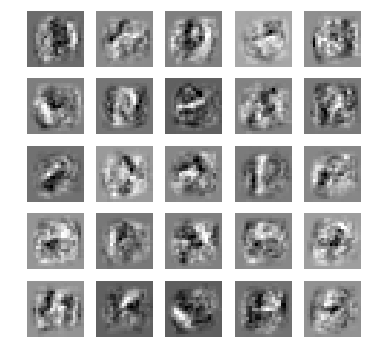

In [101]:
fig = plt.figure(figsize=(6,6))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(theta1_vis[i], interpolation='nearest', cmap=plt.cm.binary)
    plt.axis('off')
plt.show()